# Notebook Unificado

Orden de contenidos:
1. **practicaG1.ipynb**
2. **practica2G1.ipynb**
3. **practica3G1.ipynb**


---

## Contenido de **practicaG1.ipynb**

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from urllib.parse import quote_plus


In [2]:
# Credenciales base 1
user = "postgres"
password = "admin123"   # tu contraseña real
host = "localhost"
port = "5432"
database = "counterfeit"

In [3]:



# Codificar la contraseña para URL
password_encoded = quote_plus(password)

# Crear motor de conexión
engine = create_engine(
    f"postgresql+psycopg2://{user}:{password_encoded}@{host}:{port}/{database}"
)

# Leer CSV
df = pd.read_csv("data/counterfeit_transactions.csv")

# Subir a PostgreSQL
df.to_sql("counterfeit_transactions", engine, if_exists="replace", index=False)

print("✅ CSV cargado correctamente en PostgreSQL")


✅ CSV cargado correctamente en PostgreSQL


# ## 1) Carga de datos
# Intentamos leer desde **PostgreSQL** (tabla `counterfeit_transactions`).  


In [4]:
def cargar_transacciones(engine):
    if engine is not None:
        try:
            df = pd.read_sql("SELECT * FROM counterfeit_transactions", engine)
            print(f"Leído desde PostgreSQL: {df.shape}")
            return df
        except Exception as e:
            print(f"⚠️ No se pudo leer desde PostgreSQL: {e}")
    # fallback CSV
    df = pd.read_csv(CSV_PATH, low_memory=False)
    print(f"Leído desde CSV: {df.shape}")
    return df

df_transacciones = cargar_transacciones(engine)

# Normalizar tipos útiles
# Intento de parse de fecha si existe columna transaccional temporal
for col in df_transacciones.columns:
    if any(tok in col.lower() for tok in ["date", "time", "timestamp", "dt"]):
        df_transacciones[col] = pd.to_datetime(df_transacciones[col], errors="coerce")

# Campos derivados comunes
if "unit_price" in df_transacciones.columns and "quantity" in df_transacciones.columns:
    df_transacciones["monto_calculado"] = df_transacciones["unit_price"] * df_transacciones["quantity"]
if "total_amount" in df_transacciones.columns and "shipping_cost" in df_transacciones.columns:
    df_transacciones["monto_total_con_envio"] = df_transacciones["total_amount"] + df_transacciones["shipping_cost"]


Leído desde PostgreSQL: (3000, 20)


In [5]:
# Normalizar tipos útiles
# Intento de parse de fecha si existe columna transaccional temporal
for col in df_transacciones.columns:
    if any(tok in col.lower() for tok in ["date", "time", "timestamp", "dt"]):
        df_transacciones[col] = pd.to_datetime(df_transacciones[col], errors="coerce")

# Campos derivados comunes
if "unit_price" in df_transacciones.columns and "quantity" in df_transacciones.columns:
    df_transacciones["monto_calculado"] = df_transacciones["unit_price"] * df_transacciones["quantity"]
if "total_amount" in df_transacciones.columns and "shipping_cost" in df_transacciones.columns:
    df_transacciones["monto_total_con_envio"] = df_transacciones["total_amount"] + df_transacciones["shipping_cost"]

In [6]:
# ## 2) Exploración – `df_transacciones`
# **Entender columnas**: tipos, muestra, estadísticas y categorías.
# `head()` para ver primeras filas
# `info()` para tipos y nulos
# `describe()` para medidas básicas
# `value_counts()` en variables clave (método logístico, método de pago, banderas)

In [7]:
display(df_transacciones.head(10))
display(df_transacciones.info())
display(df_transacciones.describe(include="all"))

cols_categoricas = [c for c in df_transacciones.columns if df_transacciones[c].dtype == "object"]
for c in [x for x in cols_categoricas if x in ["payment_method","shipping_speed","customer_location"]]:
    print(f"\nDistribución de {c}:")
    display(df_transacciones[c].value_counts().head(10))

,transaction_id,customer_id,transaction_date,customer_age,customer_location,quantity,unit_price,total_amount,payment_method,shipping_speed,...,discount_percentage,shipping_cost,delivery_time_days,refund_requested,velocity_flag,geolocation_mismatch,device_fingerprint_new,involves_counterfeit,monto_calculado,monto_total_con_envio
0,TXN_957334,CUST_11907,2024-10-12 03:52:13,22,JP,1,199.66,199.66,Debit Card,Express,...,0.0,5.39,1970-01-01 00:00:00.000000026,False,False,False,False,False,199.66,205.05
1,TXN_246397,CUST_27641,2024-08-18 00:36:57,62,DE,4,116.01,464.03,PayPal,Express,...,0.0,8.18,1970-01-01 00:00:00.000000025,False,False,False,False,False,464.04,472.21
2,TXN_403072,CUST_78628,2024-08-19 22:21:30,75,DE,1,42.04,42.04,Credit Card,Priority,...,0.0,8.61,1970-01-01 00:00:00.000000027,False,False,False,False,False,42.04,50.65
3,TXN_848560,CUST_98579,2025-04-16 18:49:39,56,BR,3,147.69,443.08,Credit Card,Standard,...,48.7,17.00,1970-01-01 00:00:00.000000026,False,False,False,False,False,443.07,460.08
4,TXN_270817,CUST_67519,2024-10-06 13:30:52,19,IN,4,40.70,162.80,PayPal,Priority,...,0.0,20.53,1970-01-01 00:00:00.000000001,False,False,True,False,False,162.80,183.33
5,TXN_235574,CUST_76740,2024-07-14 20:02:30,30,IN,3,298.04,894.11,Debit Card,Express,...,40.5,17.06,1970-01-01 00:00:00.000000004,False,False,False,False,False,894.12,911.17
6,TXN_539896,CUST_25980,2025-03-22 14:34:20,67,US,1,52.95,52.95,PayPal,Express,...,30.4,8.19,1970-01-01 00:00:00.000000015,False,False,False,False,False,52.95,61.14
7,TXN_831689,CUST_71988,2024-09-28 05:25:30,25,IN,1,81.40,81.40,Credit Card,Express,...,39.0,12.74,1970-01-01 00:00:00.000000014,False,False,False,False,False,81.40,94.14
8,TXN_743257,CUST_72363,2024-09-27 13:10:51,66,US,1,79.57,79.57,PayPal,Standard,...,0.0,7.93,1970-01-01 00:00:00.000000013,False,False,False,False,False,79.57,87.50
9,TXN_379872,CUST_86291,2024-10-31 01:46:18,78,IN,1,193.72,193.72,PayPal,Standard,...,27.6,21.37,1970-01-01 00:00:00.000000019,False,False,False,False,False,193.72,215.09


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           3000 non-null   object        
 1   customer_id              3000 non-null   object        
 2   transaction_date         3000 non-null   datetime64[ns]
 3   customer_age             3000 non-null   int64         
 4   customer_location        3000 non-null   object        
 5   quantity                 3000 non-null   int64         
 6   unit_price               3000 non-null   float64       
 7   total_amount             3000 non-null   float64       
 8   payment_method           3000 non-null   object        
 9   shipping_speed           3000 non-null   object        
 10  customer_history_orders  3000 non-null   int64         
 11  discount_applied         3000 non-null   bool          
 12  discount_percentage      3000 non-

None

,transaction_id,customer_id,transaction_date,customer_age,customer_location,quantity,unit_price,total_amount,payment_method,shipping_speed,...,discount_percentage,shipping_cost,delivery_time_days,refund_requested,velocity_flag,geolocation_mismatch,device_fingerprint_new,involves_counterfeit,monto_calculado,monto_total_con_envio
count,3000,3000,3000,3000.000000,3000,3000.000000,3000.000000,3000.000000,3000,3000,...,3000.000000,3000.000000,3000,3000,3000,3000,3000,3000,3000.000000,3000.000000
unique,2997,2953,NaN,NaN,10,NaN,NaN,NaN,6,4,...,NaN,NaN,NaN,2,2,2,2,2,NaN,NaN
top,TXN_152377,CUST_23163,NaN,NaN,GB,NaN,NaN,NaN,PayPal,Standard,...,NaN,NaN,NaN,False,False,False,False,False,NaN,NaN
freq,2,3,NaN,NaN,325,NaN,NaN,NaN,771,1099,...,NaN,NaN,NaN,2460,2678,2515,2431,2267,NaN,NaN
mean,NaN,NaN,2025-01-04 01:09:03.542666496,48.665667,NaN,4.372333,133.781473,431.415573,NaN,NaN,...,8.573100,14.874780,1970-01-01 00:00:00.000000015,NaN,NaN,NaN,NaN,NaN,431.415923,446.290353
min,NaN,NaN,2024-07-04 16:50:04,18.000000,NaN,1.000000,5.200000,6.280000,NaN,NaN,...,0.000000,5.000000,1970-01-01 00:00:00.000000001,NaN,NaN,NaN,NaN,NaN,6.280000,13.570000
25%,NaN,NaN,2024-10-06 05:21:13.500000,33.000000,NaN,2.000000,60.145000,171.685000,NaN,NaN,...,0.000000,9.950000,1970-01-01 00:00:00.000000008,NaN,NaN,NaN,NaN,NaN,171.685000,186.552500
50%,NaN,NaN,2025-01-04 12:42:22.500000,48.000000,NaN,3.000000,112.465000,322.585000,NaN,NaN,...,0.000000,14.780000,1970-01-01 00:00:00.000000015,NaN,NaN,NaN,NaN,NaN,322.580000,337.510000
75%,NaN,NaN,2025-04-05 06:56:04,64.000000,NaN,4.000000,210.372500,623.160000,NaN,NaN,...,13.700000,19.765000,1970-01-01 00:00:00.000000022,NaN,NaN,NaN,NaN,NaN,623.137500,634.345000
max,NaN,NaN,2025-07-04 10:14:52,79.000000,NaN,19.000000,299.590000,1865.660000,NaN,NaN,...,50.000000,24.990000,1970-01-01 00:00:00.000000029,NaN,NaN,NaN,NaN,NaN,1865.610000,1883.390000



Distribución de customer_location:


customer_location
GB    325
MX    313
DE    312
CA    307
BR    304
JP    301
IN    301
AU    288
US    281
FR    268
Name: count, dtype: int64


Distribución de payment_method:


payment_method
PayPal            771
Credit Card       760
Apple Pay         554
Debit Card        550
Wire Transfer     194
Cryptocurrency    171
Name: count, dtype: int64


Distribución de shipping_speed:


shipping_speed
Standard    1099
Express      798
Priority     705
Economy      398
Name: count, dtype: int64

In [8]:
# ## 3) Filtros – `df_transacciones`
# Creamos **tres filtros** representativos:
# 1. **Transacciones de alto valor** (p. ej., top 10% por `total_amount`).
# 2. **Transacciones de riesgo**: si existe `velocity_flag`, `geolocation_mismatch` o `refund_requested`.
# 3. **Descuentos altos**: `discount_applied=True` y `discount_percentage >= 0.3` (30%) si esa columna existe.

In [9]:
def percentil(series, p=0.9):
    try:
        return series.quantile(p)
    except Exception:
        return None

filtros_transacciones = {}

if "total_amount" in df_transacciones.columns:
    umbral_top = percentil(df_transacciones["total_amount"], 0.9) or 0
    filtros_transacciones["alto_valor"] = df_transacciones[df_transacciones["total_amount"] >= umbral_top]

riesgo_cols = [c for c in ["velocity_flag","geolocation_mismatch","refund_requested"] if c in df_transacciones.columns]
if riesgo_cols:
    filtros_transacciones["riesgo_flags"] = df_transacciones[df_transacciones[riesgo_cols].fillna(False).any(axis=1)]

if all(c in df_transacciones.columns for c in ["discount_applied","discount_percentage"]):
    filtros_transacciones["descuento_alto"] = df_transacciones[
        (df_transacciones["discount_applied"] == True) &
        (df_transacciones["discount_percentage"].fillna(0) >= 0.30)
    ]

# Resumen de tamaños
for nombre, dfx in filtros_transacciones.items():
    print(f"{nombre}: {dfx.shape}")

alto_valor: (300, 22)
riesgo_flags: (1165, 22)
descuento_alto: (931, 22)


In [10]:
# ## 4) DataFrame de **Clientes** – `df_clientes`
# Agregamos por `customer_id`:
# - `total_pedidos`, `monto_total`, `ticket_promedio`
# - `tasa_reembolso` (si existe `refund_requested`)
# - `flags_riesgo` suma de (`velocity_flag`, `geolocation_mismatch`)
#
# Luego exploramos y generamos **tres filtros**:
# 1. **clientes_vip**: top 10% por `monto_total`
# 2. **clientes_riesgosos**: `tasa_reembolso >= 0.3` o `flags_riesgo > 0`
# 3. **clientes_frecuentes**: `total_pedidos >= 5`

In [11]:
from numpy import mean

def construir_df_clientes(df):
    req_cols = ["customer_id"]
    if not all(c in df.columns for c in req_cols):
        raise ValueError("No existe 'customer_id' en el dataset.")
    g = df.groupby("customer_id", dropna=False)

    out = pd.DataFrame({
        "total_pedidos": g.size(),
    })
    if "total_amount" in df.columns:
        out["monto_total"] = g["total_amount"].sum()
        out["ticket_promedio"] = g["total_amount"].mean()

    if "refund_requested" in df.columns:
        out["reembolsos"] = g["refund_requested"].sum()
        out["tasa_reembolso"] = (out["reembolsos"] / out["total_pedidos"]).round(3)
    else:
        out["tasa_reembolso"] = 0.0

    riesgo_sum = 0
    for flag in ["velocity_flag","geolocation_mismatch"]:
        if flag in df.columns:
            riesgo_sum = riesgo_sum + g[flag].sum()
    out["flags_riesgo"] = riesgo_sum if isinstance(riesgo_sum, pd.Series) else 0

    # trae alguna referencia demográfica si existe
    if "customer_location" in df.columns:
        out["customer_location_mas_comun"] = g["customer_location"].agg(lambda s: s.mode().iloc[0] if not s.mode().empty else None)

    out = out.reset_index()
    return out

df_clientes = construir_df_clientes(df_transacciones)

# Exploración
display(df_clientes.head(10))
display(df_clientes.describe(include="all"))

# Filtros (3)
filtros_clientes = {}
if "monto_total" in df_clientes.columns:
    umbral_vip = percentil(df_clientes["monto_total"], 0.9) or 0
    filtros_clientes["clientes_vip"] = df_clientes[df_clientes["monto_total"] >= umbral_vip]

filtros_clientes["clientes_frecuentes"] = df_clientes[df_clientes["total_pedidos"] >= 5]

if "tasa_reembolso" in df_clientes.columns:
    filtros_clientes["clientes_riesgosos"] = df_clientes[
        (df_clientes["tasa_reembolso"] >= 0.30) | (df_clientes["flags_riesgo"] > 0)
    ]

for nombre, dfx in filtros_clientes.items():
    print(f"{nombre}: {dfx.shape}")


,customer_id,total_pedidos,monto_total,ticket_promedio,reembolsos,tasa_reembolso,flags_riesgo,customer_location_mas_comun
0,CUST_10002,1,228.56,228.56,0,0.0,0,IN
1,CUST_10008,1,176.69,176.69,0,0.0,1,IN
2,CUST_10026,1,304.62,304.62,0,0.0,0,GB
3,CUST_10040,1,993.86,993.86,0,0.0,0,GB
4,CUST_10123,1,345.20,345.20,1,1.0,0,MX
5,CUST_10170,1,310.84,310.84,1,1.0,0,DE
6,CUST_10173,1,299.40,299.40,0,0.0,0,GB
7,CUST_10266,1,874.18,874.18,0,0.0,0,GB
8,CUST_10310,2,858.38,429.19,0,0.0,1,GB
9,CUST_10341,1,459.42,459.42,0,0.0,0,IN


,customer_id,total_pedidos,monto_total,ticket_promedio,reembolsos,tasa_reembolso,flags_riesgo,customer_location_mas_comun
count,2953,2953.000000,2953.000000,2953.000000,2953.000000,2953.000000,2953.000000,2953
unique,2953,NaN,NaN,NaN,NaN,NaN,NaN,10
top,CUST_10002,NaN,NaN,NaN,NaN,NaN,NaN,GB
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,320
mean,NaN,1.015916,438.281991,431.220619,0.182865,0.181172,0.273281,NaN
std,NaN,0.127850,338.760759,330.099076,0.386621,0.384125,0.488507,NaN
min,NaN,1.000000,6.280000,6.280000,0.000000,0.000000,0.000000,NaN
25%,NaN,1.000000,172.620000,172.030000,0.000000,0.000000,0.000000,NaN
50%,NaN,1.000000,330.240000,324.490000,0.000000,0.000000,0.000000,NaN
75%,NaN,1.000000,634.010000,623.310000,0.000000,0.000000,1.000000,NaN


clientes_vip: (296, 8)
clientes_frecuentes: (0, 8)
clientes_riesgosos: (1159, 8)


In [12]:
# ## 5) DataFrame de **Logística** – `df_logistica`
# A partir de columnas típicas (`shipping_speed`, `delivery_time_days`, `shipping_cost`):
# - Mapear un **SLA** (días objetivo por velocidad).
# - Calcular `cumple_sla` y analizar desempeño promedio por velocidad/envío.
#
# Filtros (3):
# 1. `envios_fuera_sla`: `cumple_sla == False`
# 2. `envios_costosos`: `shipping_cost` en top 10%
# 3. `envios_lentos`: `delivery_time_days >= 10`

In [13]:
def construir_df_logistica(df):
    req = ["shipping_speed","delivery_time_days","shipping_cost"]
    if not all(c in df.columns for c in req):
        raise ValueError("Faltan columnas logísticas (shipping_speed, delivery_time_days, shipping_cost).")

    df2 = df[req].copy()
    # normaliza tipos
    df2["delivery_time_days"] = pd.to_numeric(df2["delivery_time_days"], errors="coerce")
    df2["shipping_cost"] = pd.to_numeric(df2["shipping_cost"], errors="coerce")

    # SLA sugerido (ajusta según tu dominio)
    sla_map = {
        "standard": 7,
        "economy": 8,
        "express": 3,
        "two_day": 2,
        "overnight": 1
    }
    # normaliza etiquetas
    def norm(x):
        return str(x).strip().lower() if pd.notna(x) else x
    df2["shipping_speed_norm"] = df2["shipping_speed"].apply(norm)
    df2["sla_dias"] = df2["shipping_speed_norm"].map(sla_map).fillna(5)  # default 5 días
    df2["cumple_sla"] = df2["delivery_time_days"] <= df2["sla_dias"]

    # Agregación por velocidad
    agg = df2.groupby("shipping_speed_norm").agg(
        pedidos=("shipping_speed_norm","count"),
        costo_promedio=("shipping_cost","mean"),
        demora_promedio=("delivery_time_days","mean"),
        sla_dias=("sla_dias","first"),
        tasa_cumplimiento=("cumple_sla", "mean")
    ).reset_index()

    return df2, agg

df_logistica, df_logistica_resumen = construir_df_logistica(df_transacciones)

# Exploración
display(df_logistica.head(10))
display(df_logistica_resumen)

# Filtros (3)
filtros_logistica = {}
filtros_logistica["envios_fuera_sla"] = df_logistica[df_logistica["cumple_sla"] == False]

p90_costo = percentil(df_logistica["shipping_cost"].dropna(), 0.9) or 0
filtros_logistica["envios_costosos"] = df_logistica[df_logistica["shipping_cost"] >= p90_costo]

filtros_logistica["envios_lentos"] = df_logistica[df_logistica["delivery_time_days"] >= 10]

for nombre, dfx in filtros_logistica.items():
    print(f"{nombre}: {dfx.shape}")

,shipping_speed,delivery_time_days,shipping_cost,shipping_speed_norm,sla_dias,cumple_sla
0,Express,26,5.39,express,3.0,False
1,Express,25,8.18,express,3.0,False
2,Priority,27,8.61,priority,5.0,False
3,Standard,26,17.00,standard,7.0,False
4,Priority,1,20.53,priority,5.0,True
5,Express,4,17.06,express,3.0,False
6,Express,15,8.19,express,3.0,False
7,Express,14,12.74,express,3.0,False
8,Standard,13,7.93,standard,7.0,False
9,Standard,19,21.37,standard,7.0,False


,shipping_speed_norm,pedidos,costo_promedio,demora_promedio,sla_dias,tasa_cumplimiento
0,economy,398,15.125302,14.791457,8.0,0.271357
1,express,798,14.652343,15.337093,3.0,0.100251
2,priority,705,14.755277,14.814184,5.0,0.178723
3,standard,1099,15.022229,15.076433,7.0,0.228389


envios_fuera_sla: (2435, 6)
envios_costosos: (301, 6)
envios_lentos: (2088, 6)


---

## Contenido de **practica2G1.ipynb**

In [14]:
import pandas as pd
from sqlalchemy import create_engine
from urllib.parse import quote_plus


In [15]:
# Credenciales base 2
user = "postgres"
password = "admin123"   # tu contraseña real
host = "localhost"
port = "5432"
database = "ecommerce"

In [16]:
# Codificar la contraseña para URL
password_encoded = quote_plus(password)

# Crear motor de conexión
engine = create_engine(
    f"postgresql+psycopg2://{user}:{password_encoded}@{host}:{port}/{database}"
)

# Leer CSV
df = pd.read_csv("data/olist_customers_dataset.csv")

# Subir a PostgreSQL
df.to_sql("counterfeit_transactions", engine, if_exists="replace", index=False)

print("✅ CSV cargado correctamente en PostgreSQL")

✅ CSV cargado correctamente en PostgreSQL


# ## Crear tabla en PostgreSQL y cargar datos
# Usamos `pandas.to_sql` para cargar todo el dataset a la base `olist` en la tabla `olist_customers`.

In [17]:
df.to_sql("olist_customers", engine, if_exists="replace", index=False)
print("✅ Datos cargados en la tabla 'olist_customers'")

✅ Datos cargados en la tabla 'olist_customers'


# ## DataFrame 1 – Clientes (`df_clientes`)
# Contiene los identificadores principales de clientes.
# - customer_id
# - customer_unique_id
# - customer_zip_code_prefix
#
# **Filtros:**
# 1. Clientes únicos por `customer_unique_id`.
# 2. Clientes con ZIP > 90000.
# 3. Clientes duplicados en `customer_id`.


In [18]:
df_clientes = df[["customer_id","customer_unique_id","customer_zip_code_prefix"]].copy()
print("Clientes:", df_clientes.shape)
df_clientes.head()

# Filtros
clientes_unicos = df_clientes.drop_duplicates(subset=["customer_unique_id"])
clientes_zip_altos = df_clientes[df_clientes["customer_zip_code_prefix"] > 90000]
clientes_duplicados = df_clientes[df_clientes.duplicated(subset=["customer_id"], keep=False)]

Clientes: (99441, 3)


# ## DataFrame 2 – Ubicaciones (`df_ubicaciones`)
# Información de localización.
# - customer_city
# - customer_state
#
# **Filtros:**
# 1. Clientes del estado "SP".
# 2. Clientes de ciudades con más de 500 registros.
# 3. Clientes de estados diferentes de "SP" y "RJ".

In [19]:
df_ubicaciones = df[["customer_id","customer_city","customer_state"]].copy()
print("Ubicaciones:", df_ubicaciones.shape)
df_ubicaciones.head()

# Filtros
clientes_sp = df_ubicaciones[df_ubicaciones["customer_state"] == "SP"]
clientes_ciudades_top = df_ubicaciones[df_ubicaciones["customer_city"].isin(
    df_ubicaciones["customer_city"].value_counts().head(10).index
)]
clientes_otro_estado = df_ubicaciones[~df_ubicaciones["customer_state"].isin(["SP","RJ"])]


Ubicaciones: (99441, 3)


# ## DataFrame 3 – Identificadores (`df_identificadores`)
# Validación de consistencia entre IDs y duplicados.
# - customer_id
# - customer_unique_id
#
# **Filtros:**
# 1. IDs únicos → conteo de `customer_id`.
# 2. Revisión de duplicados en `customer_unique_id`.
# 3. Top 10 IDs con más repeticiones.

In [20]:
df_identificadores = df[["customer_id","customer_unique_id"]].copy()

# Filtros
total_ids_unicos = df_identificadores["customer_id"].nunique()
duplicados_unique_id = df_identificadores[df_identificadores.duplicated(subset=["customer_unique_id"], keep=False)]
top_ids = df_identificadores["customer_unique_id"].value_counts().head(10)

print("Total customer_id únicos:", total_ids_unicos)
print("Duplicados en customer_unique_id:", duplicados_unique_id.shape)
print("Top 10 customer_unique_id repetidos:")
print(top_ids)

Total customer_id únicos: 99441
Duplicados en customer_unique_id: (6342, 2)
Top 10 customer_unique_id repetidos:
customer_unique_id
8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
1b6c7548a2a1f9037c1fd3ddfed95f33     7
ca77025e7201e3b30c44b472ff346268     7
6469f99c1f9dfae7733b25662e7f1782     7
63cfc61cee11cbe306bff5857d00bfe4     6
47c1a3033b8b77b3ab6e109eb4d5fdf3     6
12f5d6e1cbf93dafd9dcc19095df0b3d     6
de34b16117594161a6a89c50b289d35a     6
dc813062e0fc23409cd255f7f53c7074     6
Name: count, dtype: int64


---

## Contenido de **practica3G1.ipynb**

In [21]:
import pandas as pd
from sqlalchemy import create_engine
from urllib.parse import quote_plus


In [22]:
# Credenciales base 3
user = "postgres"
password = "admin123"   # tu contraseña real
host = "localhost"
port = "5432"
database = "customers"

In [23]:
# Codificar la contraseña para URL
password_encoded = quote_plus(password)

# Crear motor de conexión
engine = create_engine(
    f"postgresql+psycopg2://{user}:{password_encoded}@{host}:{port}/{database}"
)

# Leer CSV
df = pd.read_csv("data/Customer_DF.csv")

# Subir a PostgreSQL
df.to_sql("counterfeit_transactions", engine, if_exists="replace", index=False)

print("✅ CSV cargado correctamente en PostgreSQL")

✅ CSV cargado correctamente en PostgreSQL


In [24]:
# Ruta CSV
csv_path = "data/Customer_DF.csv"

# Cargar CSV en pandas
df = pd.read_csv(csv_path)
print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (168, 10)


,Unnamed: 0,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,No_Transactions,No_Orders,No_Payments,Fraud
0,0,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\r\nBrownside, CA 51896",2,2,1,False
1,1,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\r\nPort Joshuabu...,3,3,7,True
2,2,andersonwilliam@yahoo.com,024.420.0375,4m7h5ipl1shyavt6vv2r,67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0,"8478 Sean Ridges Apt. 441\r\nDavisberg, PR 72250",5,3,2,False
3,3,rubenjuarez@yahoo.com,670.664.8168x94985,slovx60t0i558may4ks0,95de:8565:5a66:792c:26e0:6cfb:7d87:11af,"7769 Elizabeth Bridge Apt. 343\r\nNortonstad, ...",3,3,1,False
4,4,uchen@malone.com,1-981-877-0870,j0pd24k5h8dl2fqu0cz4,196.89.235.192,148 Russell Lodge Apt. 445\r\nPort Jennifersid...,7,7,6,True


In [25]:

df.to_sql("customer_df", engine, if_exists="replace", index=False)
print("✅ Datos cargados en la tabla 'customer_df'")


✅ Datos cargados en la tabla 'customer_df'


# ## 2. DataFrame de Contacto (`df_contacto`)
# Incluye los datos de identificación del cliente: email, teléfono, dispositivo, IP.
# **Filtros:**
# 1. Correos con dominio `gmail.com`.
# 2. Dispositivos móviles.
# 3. IPs duplicadas.

In [26]:
df_contacto = df[["customerEmail","customerPhone","customerDevice","customerIPAddress"]].copy()
print("DataFrame Contacto:", df_contacto.shape)
display(df_contacto.head(10))

# Filtro 1: emails de Gmail
gmail_users = df_contacto[df_contacto["customerEmail"].str.contains("gmail", case=False, na=False)]
display(gmail_users.head())

# Filtro 2: dispositivos móviles
mobile_users = df_contacto[df_contacto["customerDevice"].str.contains("mobile", case=False, na=False)]
display(mobile_users.head())

# Filtro 3: IPs duplicadas
duplicated_ips = df_contacto[df_contacto.duplicated(subset=["customerIPAddress"], keep=False)]
display(duplicated_ips.head())


DataFrame Contacto: (168, 4)


,customerEmail,customerPhone,customerDevice,customerIPAddress
0,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40
1,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202
2,andersonwilliam@yahoo.com,024.420.0375,4m7h5ipl1shyavt6vv2r,67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0
3,rubenjuarez@yahoo.com,670.664.8168x94985,slovx60t0i558may4ks0,95de:8565:5a66:792c:26e0:6cfb:7d87:11af
4,uchen@malone.com,1-981-877-0870,j0pd24k5h8dl2fqu0cz4,196.89.235.192
5,robinsoncynthia@dunn.com,+65(5)8997489788,hbww39m1wenbq4ymjhsx,43.166.163.164
6,samuel15@saunders-rhodes.com,05045239487,up7afvce5v0omniqlevq,33.67.35.30
7,johnlowery@gmail.com,044-642-9860,rjb0adai34izqvys4938,212.144.68.190
8,jameslandry@rodriguez.com,1-885-168-1310x338,yz4l2bgbvzra5eb5qcan,c899:ff67:6864:4365:def3:3023:655f:5181
9,ubranch@rivera-parker.info,(772)964-8162x6310,6mpx027neyz6sh04n3ue,86.16.65.228


,customerEmail,customerPhone,customerDevice,customerIPAddress
7,johnlowery@gmail.com,044-642-9860,rjb0adai34izqvys4938,212.144.68.190
15,gonzalesjackson@gmail.com,1-410-373-1228x129,hmkn4nmfc5q5mgify2zw,229.2.225.188
26,avaldez@gmail.com,203-573-2041,bwgvb5w8dm6upvi7ucqc,46.130.37.206
29,catherine64@gmail.com,563-396-2038x288,myjxxvd3jfn1eymfy50n,1289:d2a9:c65d:8fc7:7be4:129b:d7b:cf7b
40,johnlowery@gmail.com,737-377-9701x577,jz66ap43id2y35ivfqa5,6c21:ac1d:2089:68fa:abb7:8c00:525f:6588


,customerEmail,customerPhone,customerDevice,customerIPAddress


,customerEmail,customerPhone,customerDevice,customerIPAddress
46,jamescampbell@randall-pacheco.biz,599-142-6783,eaul63h9guyvwuymfn3z,45.203.99.249
80,warrenedward@arnold.com,201.737.5119x64000,6py7ewqjkxjw8zjl9eri,45.203.99.249
88,shelby24@hotmail.com,(071)934-3315x27613,obb41ux0zfa2td5ajo9s,45.203.99.249
141,christinemills@mcgee.com,(651)355-4709,zbn9it3s7yl69bjtrnqf,45.203.99.249


# ## 3. DataFrame de Transacciones (`df_transacciones`)
# Contiene variables numéricas de actividad: transacciones, órdenes y pagos.
# **Filtros:**
# 1. Clientes con más de 5 transacciones.
# 2. Clientes con más de 3 órdenes.
# 3. Clientes con pagos = 0.

In [27]:
df_transacciones = df[["customerEmail","No_Transactions","No_Orders","No_Payments"]].copy()
print("DataFrame Transacciones:", df_transacciones.shape)
display(df_transacciones.head(10))

# Filtro 1: más de 5 transacciones
filtro_trans = df_transacciones[df_transacciones["No_Transactions"] > 5]
display(filtro_trans.head())

# Filtro 2: más de 3 órdenes
filtro_ordenes = df_transacciones[df_transacciones["No_Orders"] > 3]
display(filtro_ordenes.head())

# Filtro 3: sin pagos
filtro_sin_pagos = df_transacciones[df_transacciones["No_Payments"] == 0]
display(filtro_sin_pagos.head())

DataFrame Transacciones: (168, 4)


,customerEmail,No_Transactions,No_Orders,No_Payments
0,josephhoward@yahoo.com,2,2,1
1,evansjeffery@yahoo.com,3,3,7
2,andersonwilliam@yahoo.com,5,3,2
3,rubenjuarez@yahoo.com,3,3,1
4,uchen@malone.com,7,7,6
5,robinsoncynthia@dunn.com,1,1,2
6,samuel15@saunders-rhodes.com,2,1,2
7,johnlowery@gmail.com,6,5,2
8,jameslandry@rodriguez.com,5,2,1
9,ubranch@rivera-parker.info,0,0,1


,customerEmail,No_Transactions,No_Orders,No_Payments
4,uchen@malone.com,7,7,6
7,johnlowery@gmail.com,6,5,2
10,bowenwilliam@yahoo.com,6,5,1
11,ksummers@hotmail.com,7,5,4
16,dana09@yahoo.com,6,3,2


,customerEmail,No_Transactions,No_Orders,No_Payments
4,uchen@malone.com,7,7,6
7,johnlowery@gmail.com,6,5,2
10,bowenwilliam@yahoo.com,6,5,1
11,ksummers@hotmail.com,7,5,4
12,christineklein@wright-boyd.org,4,4,3


,customerEmail,No_Transactions,No_Orders,No_Payments
34,zbennett@frazier.com,0,0,0
38,xwang@white.com,0,0,0
44,gsimpson@cox.org,0,0,0
47,johnsonjennifer@yahoo.com,0,0,0
54,zthomas@gmail.com,0,0,0


# ## 4. DataFrame de Riesgo (`df_riesgo`)
# Relaciona clientes con dirección de facturación y la etiqueta de fraude.
# **Filtros:**
# 1. Clientes marcados como fraude = 1.
# 2. Direcciones de facturación duplicadas.
# 3. Clientes con fraude y más de 2 transacciones.

In [28]:
df_riesgo = df[["customerEmail","customerBillingAddress","No_Transactions","Fraud"]].copy()
print("DataFrame Riesgo:", df_riesgo.shape)
display(df_riesgo.head(10))

# Filtro 1: fraude = 1
fraudulentos = df_riesgo[df_riesgo["Fraud"] == 1]
display(fraudulentos.head())

# Filtro 2: direcciones duplicadas
duplicated_address = df_riesgo[df_riesgo.duplicated(subset=["customerBillingAddress"], keep=False)]
display(duplicated_address.head())

# Filtro 3: fraude + más de 2 transacciones
fraude_activo = df_riesgo[(df_riesgo["Fraud"] == 1) & (df_riesgo["No_Transactions"] > 2)]
display(fraude_activo.head())

DataFrame Riesgo: (168, 4)


,customerEmail,customerBillingAddress,No_Transactions,Fraud
0,josephhoward@yahoo.com,"5493 Jones Islands\r\nBrownside, CA 51896",2,False
1,evansjeffery@yahoo.com,356 Elizabeth Inlet Suite 120\r\nPort Joshuabu...,3,True
2,andersonwilliam@yahoo.com,"8478 Sean Ridges Apt. 441\r\nDavisberg, PR 72250",5,False
3,rubenjuarez@yahoo.com,"7769 Elizabeth Bridge Apt. 343\r\nNortonstad, ...",3,False
4,uchen@malone.com,148 Russell Lodge Apt. 445\r\nPort Jennifersid...,7,True
5,robinsoncynthia@dunn.com,"65233 Hutchinson Mountains\r\nMartinezside, OR...",1,True
6,samuel15@saunders-rhodes.com,"3960 Emily Fort\r\nStaceytown, AR 21817-3325",2,True
7,johnlowery@gmail.com,"484 Pamela Pass\r\nLake Jessicaview, WI 12942-...",6,True
8,jameslandry@rodriguez.com,USNS Price\r\nFPO AE 14661,5,False
9,ubranch@rivera-parker.info,6974 Robertson Common Apt. 902\r\nPort Juansid...,0,True


,customerEmail,customerBillingAddress,No_Transactions,Fraud
1,evansjeffery@yahoo.com,356 Elizabeth Inlet Suite 120\r\nPort Joshuabu...,3,True
4,uchen@malone.com,148 Russell Lodge Apt. 445\r\nPort Jennifersid...,7,True
5,robinsoncynthia@dunn.com,"65233 Hutchinson Mountains\r\nMartinezside, OR...",1,True
6,samuel15@saunders-rhodes.com,"3960 Emily Fort\r\nStaceytown, AR 21817-3325",2,True
7,johnlowery@gmail.com,"484 Pamela Pass\r\nLake Jessicaview, WI 12942-...",6,True


,customerEmail,customerBillingAddress,No_Transactions,Fraud
57,feliciabrown@gmail.com,49680 Brian Squares Apt. 122\r\nPort Walterbur...,1,True
80,warrenedward@arnold.com,49680 Brian Squares Apt. 122\r\nPort Walterbur...,4,True
90,brittanydean@hotmail.com,49680 Brian Squares Apt. 122\r\nPort Walterbur...,6,True


,customerEmail,customerBillingAddress,No_Transactions,Fraud
1,evansjeffery@yahoo.com,356 Elizabeth Inlet Suite 120\r\nPort Joshuabu...,3,True
4,uchen@malone.com,148 Russell Lodge Apt. 445\r\nPort Jennifersid...,7,True
7,johnlowery@gmail.com,"484 Pamela Pass\r\nLake Jessicaview, WI 12942-...",6,True
10,bowenwilliam@yahoo.com,"27061 Wright Forks\r\nCraigland, MN 59915",6,True
15,gonzalesjackson@gmail.com,"566 Courtney Stream\r\nReedland, NH 84853",4,True


In [29]:
### 📌 COMPONENTE PRACTICO 2 
# # Proyecto BI – Integración de 3 Bases de Datos
# Dataset usados:
# - Counterfeit Product Detection
# - Olist Customers Dataset
# - Customer_DF (fraude/contacto)
#
# Objetivo:
# - Cargar las 3 fuentes a PostgreSQL en una sola base (`maestria_bi`)
# - Generar DataFrames exploratorios
# - Aplicar filtros
# - Explicar relaciones entre ellas

In [30]:
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus
from dotenv import load_dotenv
import os
import pandas as pd
from graphviz import Digraph
import seaborn as sns
import matplotlib.pyplot as plt


In [31]:
# CONEXIÓN A POSTGRESQL
load_dotenv()

PG_USER = os.getenv("PG_USER")
PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DB = os.getenv("PG_DB")

engine = create_engine(
    f"postgresql+psycopg2://{PG_USER}:{quote_plus(PG_PASSWORD)}@{PG_HOST}:{PG_PORT}/{PG_DB}"
)

# Probar conexión
try:
    with engine.connect() as conn:
        result = conn.execute(text("SELECT current_database(), version();"))
        print("✅ Conectado a:", result.fetchone())
except Exception as e:
    print("❌ Error de conexión:", e)


TypeError: quote_from_bytes() expected bytes

In [ ]:
# Leer los CSV
df_customer = pd.read_csv("data/Customer_DF.csv")
df_olist = pd.read_csv("data/olist_customers_dataset.csv")
df_transactions = pd.read_csv("data/counterfeit_transactions.csv")

# Subir a PostgreSQL
df_customer.to_sql("customer_df", engine, if_exists="replace", index=False)
df_olist.to_sql("olist_customers", engine, if_exists="replace", index=False)
df_transactions.to_sql("counterfeit_transactions", engine, if_exists="replace", index=False)

print("✅ Tablas creadas en PostgreSQL")


In [ ]:
# Verificar tablas
tablas = pd.read_sql("SELECT table_name FROM information_schema.tables WHERE table_schema='public';", engine)
print(tablas)

In [ ]:
# === Función para explorar tabla ===
def explorar_tabla(nombre_tabla, filas=5):
    print(f"📊 Explorando tabla: {nombre_tabla}")
    df = pd.read_sql(f'SELECT * FROM "{nombre_tabla}" LIMIT {filas};', engine)
    total = pd.read_sql(f'SELECT COUNT(*) FROM "{nombre_tabla}";', engine).iloc[0,0]
    print("Columnas:", df.columns.tolist())
    print("Número de filas:", total)
    return df

# === Explorar cada tabla ===
df_transacciones = explorar_tabla("counterfeit_transactions")
df_clientes = explorar_tabla("customer_df")
df_olist = explorar_tabla("olist_customers")

# Mostrar primeras filas de cada tabla
df_transacciones.head(), df_clientes.head(), df_olist.head()

### 3. Función limpieza general

In [ ]:
# ==============================
### 3. Función limpieza general
# ==============================
def limpiar_dataframe(df, claves=[]):
    """
    Limpieza básica de un DataFrame:
    - Elimina duplicados
    - Normaliza nombres de columnas
    - Quita nulos en columnas clave
    """
    df = df.copy()
    
    # Normalizar nombres de columnas
    df.columns = (
        df.columns.str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("-", "_")
    )
    
    # Eliminar duplicados
    df = df.drop_duplicates()
    
    # Quitar nulos en claves importantes
    for col in claves:
        if col in df.columns:
            df = df[df[col].notnull()]
    
    return df

# ==============================
# 4. Cargar y limpiar las tablas
# ==============================
df_transacciones = pd.read_sql('SELECT * FROM "counterfeit_transactions";', engine)
df_clientes = pd.read_sql('SELECT * FROM "customer_df";', engine)
df_olist = pd.read_sql('SELECT * FROM "olist_customers";', engine)

df_transacciones = limpiar_dataframe(df_transacciones, claves=["transaction_id"])
df_clientes = limpiar_dataframe(df_clientes, claves=["customer_id"])
df_olist = limpiar_dataframe(df_olist, claves=["customer_id"])

# ==============================
# 5. Guardar tablas limpias (opcional)
# ==============================
df_transacciones.to_sql("counterfeit_transactions_limpia", engine, if_exists="replace", index=False)
df_clientes.to_sql("customer_df_limpia", engine, if_exists="replace", index=False)
df_olist.to_sql("olist_customers_dataset_limpia", engine, if_exists="replace", index=False)

print("✅ Tablas limpias cargadas en PostgreSQL (con sufijo _limpia)")

In [ ]:
# ==============================
# 6. Visualización de Nulos y Duplicados
# ==============================

def visualizar_calidad_datos(df, nombre):
    """
    Muestra gráficas de:
    - Porcentaje de valores nulos por columna
    - Cantidad de duplicados
    """
    print(f"\n📊 Calidad de datos en {nombre}")
    
    # ---- Nulos ----
    nulos = df.isnull().mean() * 100
    nulos = nulos[nulos > 0].sort_values(ascending=False)
    
    if not nulos.empty:
        plt.figure(figsize=(8,4))
        sns.barplot(x=nulos.values, y=nulos.index, palette="Reds_r")
        plt.title(f"Porcentaje de valores nulos en {nombre}")
        plt.xlabel("Porcentaje (%)")
        plt.ylabel("Columnas")
        plt.show()
    else:
        print("✅ No se encontraron valores nulos")

    # ---- Duplicados ----
    duplicados = df.duplicated().sum()
    total = len(df)
    print(f"🔁 Duplicados: {duplicados} de {total} filas")

# ==============================
# Aplicar a los tres DataFrames
# ==============================
visualizar_calidad_datos(df_transacciones, "Transacciones")
visualizar_calidad_datos(df_clientes, "Clientes")
visualizar_calidad_datos(df_olist, "Olist Customers")

In [ ]:
# Resumen final de columnas
print("Counterfeit Transactions:", df_transacciones.columns.tolist())
print("Customer DF:", df_clientes.columns.tolist())
print("Olist Customers:", df_olist.columns.tolist())

Counterfeit Transactions: ['transaction_id', 'customer_id', 'transaction_date', 'customer_age', 'customer_location', 'quantity', 'unit_price', 'total_amount', 'payment_method', 'shipping_speed', 'customer_history_orders', 'discount_applied', 'discount_percentage', 'shipping_cost', 'delivery_time_days', 'refund_requested', 'velocity_flag', 'geolocation_mismatch', 'device_fingerprint_new', 'involves_counterfeit', 'monto_calculado', 'monto_total_con_envio', 'anio', 'mes']
Customer DF: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix']
Olist Customers: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']


In [ ]:
# Transformaciones necesarias (con funciones lambda si aplica)

## Aquí se derivan nuevas variables útiles y se estandarizan datos.

In [ ]:
# ==========================================================
# 7. Transformaciones
# ==========================================================

# Transacciones: derivar año y mes
df_transacciones["transaction_date"] = pd.to_datetime(df_transacciones["transaction_date"])
df_transacciones["anio"] = df_transacciones["transaction_date"].dt.year
df_transacciones["mes"] = df_transacciones["transaction_date"].dt.month

# Clientes DF: crear columna de longitud de ZIP code
df_clientes["longitud_zip"] = df_clientes["customer_zip_code_prefix"].astype(str).apply(len)

# Olist: normalizar ciudades y estados
df_olist["customer_city"] = df_olist["customer_city"].str.strip().str.title()
df_olist["customer_state"] = df_olist["customer_state"].str.upper()

# Mostrar resultados
print(df_transacciones.head())
print(df_clientes.head())
print(df_olist.head())


  transaction_id customer_id    transaction_date  customer_age  \
0     TXN_957334  CUST_11907 2024-10-12 03:52:13            22   
1     TXN_246397  CUST_27641 2024-08-18 00:36:57            62   
2     TXN_403072  CUST_78628 2024-08-19 22:21:30            75   
3     TXN_848560  CUST_98579 2025-04-16 18:49:39            56   
4     TXN_270817  CUST_67519 2024-10-06 13:30:52            19   

  customer_location  quantity  unit_price  total_amount payment_method  \
0                JP         1      199.66        199.66     Debit Card   
1                DE         4      116.01        464.03         PayPal   
2                DE         1       42.04         42.04    Credit Card   
3                BR         3      147.69        443.08    Credit Card   
4                IN         4       40.70        162.80         PayPal   

  shipping_speed  ...            delivery_time_days  refund_requested  \
0        Express  ... 1970-01-01 00:00:00.000000026             False   
1        Exp

## Expansión de DataFrame

### Aquí se agregan esas columnas transformadas/limpias directamente al DataFrame original.

In [ ]:
# 8. Expansión de los DataFrames
# ===============================

# Transacciones ya tiene año y mes
print(df_transacciones[["transaction_id", "anio", "mes"]].head())

# Clientes ahora tiene longitud de ZIP y prefijo de ID
df_clientes["id_prefijo"] = df_clientes["customer_id"].astype(str).str[:5]
print(df_clientes[["customer_id", "longitud_zip", "id_prefijo"]].head())

# Olist ya tiene ciudad y estado normalizado
print(df_olist[["customer_id", "customer_city", "customer_state"]].head())


  transaction_id  anio  mes
0     TXN_957334  2024   10
1     TXN_246397  2024    8
2     TXN_403072  2024    8
3     TXN_848560  2025    4
4     TXN_270817  2024   10
                        customer_id  longitud_zip id_prefijo
0  06b8999e2fba1a1fbc88172c00ba8bc7             5      06b89
1  18955e83d337fd6b2def6b18a428ac77             4      18955
2  4e7b3e00288586ebd08712fdd0374a03             4      4e7b3
3  b2b6027bc5c5109e529d4dc6358b12c3             4      b2b60
4  4f2d8ab171c80ec8364f7c12e35b23ad             5      4f2d8
                        customer_id          customer_city customer_state
0  06b8999e2fba1a1fbc88172c00ba8bc7                 Franca             SP
1  18955e83d337fd6b2def6b18a428ac77  Sao Bernardo Do Campo             SP
2  4e7b3e00288586ebd08712fdd0374a03              Sao Paulo             SP
3  b2b6027bc5c5109e529d4dc6358b12c3        Mogi Das Cruzes             SP
4  4f2d8ab171c80ec8364f7c12e35b23ad               Campinas             SP


In [ ]:
### 📌 Índices numéricos únicos y secuenciales

## Se crean IDs artificiales para manejar relaciones de manera más ordenada:

In [ ]:
# ==============================
# 9. Generación de índices únicos
# ==============================

df_transacciones = df_transacciones.reset_index(drop=True)
df_transacciones["id_transaccion"] = df_transacciones.index + 1

df_clientes = df_clientes.reset_index(drop=True)
df_clientes["id_cliente"] = df_clientes.index + 1

df_olist = df_olist.reset_index(drop=True)
df_olist["id_olist"] = df_olist.index + 1

### 📌 Con los tres datasets transformados y unificados, proponemos estas graficas para:
## Distribución de montos de transacciones.
## Número de clientes por estado (Olist).
## Evolución temporal de transacciones por mes

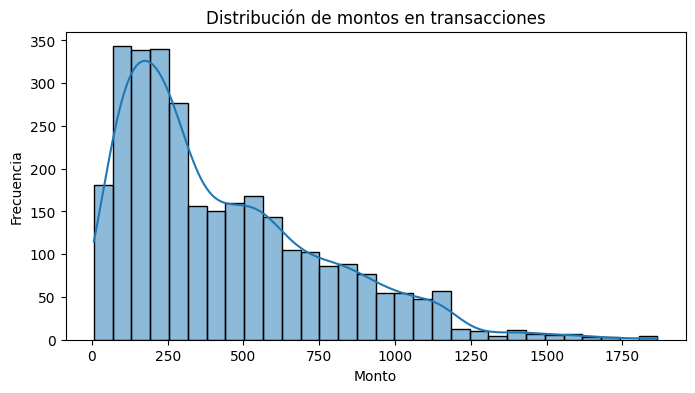

In [ ]:
#Distribución de montos de transacciones.
plt.figure(figsize=(8,4))
sns.histplot(df_transacciones["total_amount"], bins=30, kde=True)
plt.title("Distribución de montos en transacciones")
plt.xlabel("Monto")
plt.ylabel("Frecuencia")
plt.show()

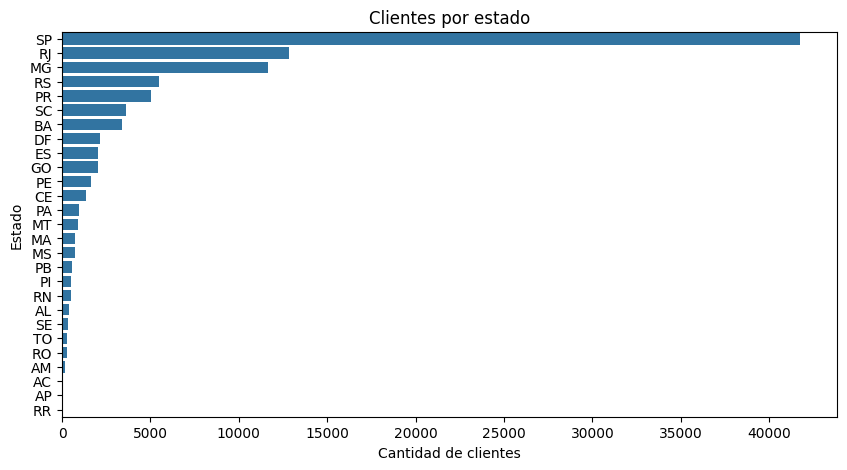

In [ ]:
# Numero de clientes por estado (Olist).
plt.figure(figsize=(10,5))
sns.countplot(y=df_olist["customer_state"], order=df_olist["customer_state"].value_counts().index)
plt.title("Clientes por estado")
plt.xlabel("Cantidad de clientes")
plt.ylabel("Estado")
plt.show()

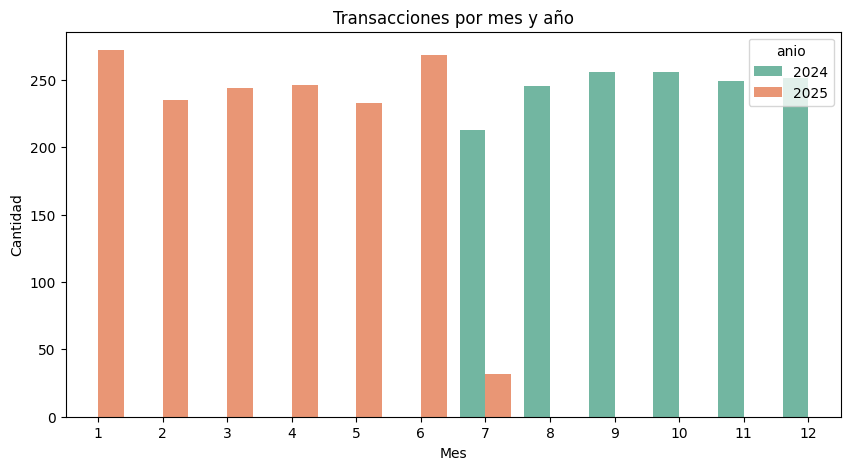

In [ ]:
# Evolución temporal de transacciones por mes

# Extraer año y mes si no existen
if "mes" not in df_transacciones.columns or "anio" not in df_transacciones.columns:
	df_transacciones["anio"] = df_transacciones["transaction_date"].dt.year
	df_transacciones["mes"] = df_transacciones["transaction_date"].dt.month

plt.figure(figsize=(10,5))
sns.countplot(x=df_transacciones["mes"], hue=df_transacciones["anio"], palette="Set2")
plt.title("Transacciones por mes y año")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
plt.show()

# Conclusiones
### En el Taller N°2 integramos tres datasets heterogéneos en una sola base de datos PostgreSQL (maestria_bi) para ### garantizar integridad y centralización.
### Se aplicaron transformaciones con pandas: derivación de anio/mes, normalización de ciudades/estados y creación de ### nuevas variables como longitud_email y monto_total_con_envio.
### La conexión se gestionó con SQLAlchemy/psycopg2, permitiendo ejecutar un pipeline ETL reproducible.
### Se validaron registros y columnas mediante consultas SQL y visualizaciones en Seaborn, identificando patrones de ### fraude y distribuciones.
### El esquema relacional con customer_id como clave integradora permitió consolidar clientes y transacciones.
### Con esto dejamos los datos listos para modelos de análisis avanzado y detección de fraude en futuras fases.